In [1]:
# imports and environment setup
import os
import glob
import random
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

# Image processing
from PIL import Image, ImageFilter
import cv2
import scipy
from scipy import fftpack
from scipy import ndimage

# Feature libraries
from skimage.feature import local_binary_pattern
import pywt  # wavelets

# ML
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


In [2]:
import os
import glob
import pandas as pd

def build_df(data_dir):
    rows = []
    for scanner_dir in os.listdir(data_dir):
        scanner_path = os.path.join(data_dir, scanner_dir)
        if not os.path.isdir(scanner_path):
            continue

        print(f"\n📁 {scanner_dir}")
        # Use a single case-insensitive pattern
        pattern = os.path.join(scanner_path, '*.[jJ][pP][gG]')
        files = glob.glob(pattern)
        print(f"  Found {len(files)} files matching JPG/jpg")

        # Also check for png, tif, bmp
        for ext in ['png', 'tif', 'bmp']:
            pattern = os.path.join(scanner_path, f'*.{ext}')
            files += glob.glob(pattern)
        
        print(f"  Total images found in {scanner_dir}: {len(files)}")

        for f in files:
            rows.append({
                'scanner': scanner_dir,
                'filename': os.path.basename(f),
                'filepath': f
            })

    df = pd.DataFrame(rows)
    print(f"\n✅ Total files found: {len(df)}")
    print(f"Columns in df: {df.columns.tolist()}")
    return df

DATA_DIR = r"C:\Users\LIKITHA\Downloads\DATA"
df = build_df(DATA_DIR)
df.head()


📁 scanner_A
  Found 5 files matching JPG/jpg
  Total images found in scanner_A: 5

📁 scanner_B
  Found 5 files matching JPG/jpg
  Total images found in scanner_B: 5

📁 scanner_C
  Found 5 files matching JPG/jpg
  Total images found in scanner_C: 5

✅ Total files found: 15
Columns in df: ['scanner', 'filename', 'filepath']


,scanner,filename,filepath
0,scanner_A,50630631-0632.jpg,C:\Users\LIKITHA\Downloads\DATA\scanner_A\5063...
1,scanner_A,50636686-6687.jpg,C:\Users\LIKITHA\Downloads\DATA\scanner_A\5063...
2,scanner_A,50638712-8712.jpg,C:\Users\LIKITHA\Downloads\DATA\scanner_A\5063...
3,scanner_A,50639278-9279.jpg,C:\Users\LIKITHA\Downloads\DATA\scanner_A\5063...
4,scanner_A,50646644-6645.jpg,C:\Users\LIKITHA\Downloads\DATA\scanner_A\5064...


In [3]:
import os
import glob
import pandas as pd

def build_df(data_dir):
    rows = []
    for scanner_dir in os.listdir(data_dir):
        scanner_path = os.path.join(data_dir, scanner_dir)
        if not os.path.isdir(scanner_path):
            continue

        print(f"\n📁 {scanner_dir}")
        
        # Only need .jpg here (since your files are all lowercase)
        pattern = os.path.join(scanner_path, '*.jpg')
        files = glob.glob(pattern)

        print(f"  Total images found in {scanner_dir}: {len(files)}")

        for f in files:
            rows.append({
                'scanner': scanner_dir,
                'filename': os.path.basename(f),
                'filepath': f
            })

    df = pd.DataFrame(rows)
    print(f"\n✅ Total files found: {len(df)}")
    print(f"Columns in df: {df.columns.tolist()}")
    return df


DATA_DIR = r"C:\Users\LIKITHA\Downloads\data"
df = build_df(DATA_DIR)
print("\n✅ DataFrame shape:", df.shape)
df.head()


📁 scanner_A
  Total images found in scanner_A: 5

📁 scanner_B
  Total images found in scanner_B: 5

📁 scanner_C
  Total images found in scanner_C: 5

✅ Total files found: 15
Columns in df: ['scanner', 'filename', 'filepath']

✅ DataFrame shape: (15, 3)


,scanner,filename,filepath
0,scanner_A,50630631-0632.jpg,C:\Users\LIKITHA\Downloads\data\scanner_A\5063...
1,scanner_A,50636686-6687.jpg,C:\Users\LIKITHA\Downloads\data\scanner_A\5063...
2,scanner_A,50638712-8712.jpg,C:\Users\LIKITHA\Downloads\data\scanner_A\5063...
3,scanner_A,50639278-9279.jpg,C:\Users\LIKITHA\Downloads\data\scanner_A\5063...
4,scanner_A,50646644-6645.jpg,C:\Users\LIKITHA\Downloads\data\scanner_A\5064...


In [4]:
from PIL import Image

def image_props(path):
    """Extract width, height, and mode for an image."""
    try:
        with Image.open(path) as img:
            return img.size[0], img.size[1], img.mode
    except Exception as e:
        print(f"⚠ Error reading {path}: {e}")
        return None, None, None

# Apply to all images
props = df['filepath'].apply(image_props)

# Convert list of tuples → DataFrame
props_df = pd.DataFrame(props.tolist(), columns=['width', 'height', 'mode'])

# Combine with original DataFrame
summary = pd.concat([df.reset_index(drop=True), props_df], axis=1)

# Print a quick summary per scanner
print("\n📊 Summary by scanner:")
print(summary.groupby('scanner').agg({'filepath': 'count', 'width': 'median', 'height': 'median'}))

# Show first few rows
summary.head()


📊 Summary by scanner:
           filepath   width  height
scanner                            
scanner_A         5  1728.0  2292.0
scanner_B         5  1728.0  2292.0
scanner_C         5  1728.0  2292.0


,scanner,filename,filepath,width,height,mode
0,scanner_A,50630631-0632.jpg,C:\Users\LIKITHA\Downloads\data\scanner_A\5063...,1728,2292,L
1,scanner_A,50636686-6687.jpg,C:\Users\LIKITHA\Downloads\data\scanner_A\5063...,1728,2292,L
2,scanner_A,50638712-8712.jpg,C:\Users\LIKITHA\Downloads\data\scanner_A\5063...,1728,2292,L
3,scanner_A,50639278-9279.jpg,C:\Users\LIKITHA\Downloads\data\scanner_A\5063...,1728,2292,L
4,scanner_A,50646644-6645.jpg,C:\Users\LIKITHA\Downloads\data\scanner_A\5064...,1728,2292,L


In [5]:
# Cell: preprocessing helpers
TARGET_SIZE = (512, 512)   # try 512 or 256; PRNU often better with larger images
PATCH_SIZE = 256           # if extracting patches
PATCHES_PER_IMAGE = 4      # increase dataset size by extracting patches

def preprocess_image(path, target_size=TARGET_SIZE, to_gray=True):
    img = Image.open(path)
    # Convert to RGB if paletted / other
    if img.mode not in ('L', 'RGB'):
        img = img.convert('RGB')
    if to_gray:
        img = img.convert('L')
    img = img.resize(target_size, Image.BILINEAR)
    arr = np.array(img).astype(np.float32)
    return arr

def extract_center_patches(arr, patch_size=PATCH_SIZE, n_patches=4):
    h, w = arr.shape[:2]
    patches = []
    if n_patches == 1:
        y0, x0 = (h - patch_size)//2, (w - patch_size)//2
        patches.append(arr[y0:y0+patch_size, x0:x0+patch_size])
    else:
        # corners + center as simple strategy
        coords = [
            (0,0),
            (0,w-patch_size),
            (h-patch_size,0),
            (h-patch_size,w-patch_size),
        ]
        for (y,x) in coords[:n_patches]:
            patches.append(arr[y:y+patch_size, x:x+patch_size])
    return patches

# Example: preprocess a few images and save to preprocessed folder
PREPROC_DIR = "preprocessed"
os.makedirs(PREPROC_DIR, exist_ok=True)

# create a small preview (not mandatory)
for i, row in df.head(4).iterrows():
    arr = preprocess_image(row['filepath'])
    patches = extract_center_patches(arr, n_patches=PATCHES_PER_IMAGE)
    # save patches for visual inspection
    base = Path(row['filepath']).stem
    lab = row['scanner']
    outdir = os.path.join(PREPROC_DIR, lab)
    os.makedirs(outdir, exist_ok=True)
    for idx,p in enumerate(patches):
        outpath = os.path.join(outdir, f"{base}_patch{idx}.png")
        Image.fromarray(p.astype(np.uint8)).save(outpath)

In [6]:
# --- TEST the preprocessing functions ---
from pathlib import Path
from PIL import Image
import numpy as np
import os

# ⚠ Make sure you already have your dataframe 'df' built from earlier (with 'filepath' column)

# Create a folder to save preprocessed images
PREPROC_DIR = "preprocessed"
os.makedirs(PREPROC_DIR, exist_ok=True)

# Test with a few images (first 3 rows from df)
for i, row in df.head(3).iterrows():
    arr = preprocess_image(row['filepath'])  # <-- Use 'filepath', not 'file_path'
    patches = extract_center_patches(arr, n_patches=4)
    
    base = Path(row['filepath']).stem
    lab = row['scanner']
    outdir = os.path.join(PREPROC_DIR, lab)
    os.makedirs(outdir, exist_ok=True)
    
    for idx, p in enumerate(patches):
        outpath = os.path.join(outdir, f"{base}_patch{idx}.png")
        Image.fromarray(p.astype(np.uint8)).save(outpath)
        print(f"✅ Saved patch: {outpath}")

print("\n🎉 Preprocessing complete! Check your 'preprocessed' folder.")

✅ Saved patch: preprocessed\scanner_A\50630631-0632_patch0.png
✅ Saved patch: preprocessed\scanner_A\50630631-0632_patch1.png
✅ Saved patch: preprocessed\scanner_A\50630631-0632_patch2.png
✅ Saved patch: preprocessed\scanner_A\50630631-0632_patch3.png
✅ Saved patch: preprocessed\scanner_A\50636686-6687_patch0.png
✅ Saved patch: preprocessed\scanner_A\50636686-6687_patch1.png
✅ Saved patch: preprocessed\scanner_A\50636686-6687_patch2.png
✅ Saved patch: preprocessed\scanner_A\50636686-6687_patch3.png
✅ Saved patch: preprocessed\scanner_A\50638712-8712_patch0.png
✅ Saved patch: preprocessed\scanner_A\50638712-8712_patch1.png
✅ Saved patch: preprocessed\scanner_A\50638712-8712_patch2.png
✅ Saved patch: preprocessed\scanner_A\50638712-8712_patch3.png

🎉 Preprocessing complete! Check your 'preprocessed' folder.


In [35]:
# Cell: FFT-based features
def fft_features(img_arr, n_bands=6):
    # img_arr assumed grayscale 2D
    f = fftpack.fft2(img_arr)
    fshift = fftpack.fftshift(f)
    magnitude = np.abs(fshift)
    # compute radial frequency bands
    h, w = img_arr.shape
    cy, cx = h//2, w//2
    Y, X = np.ogrid[:h, :w]
    r = np.sqrt((X-cx)*2 + (Y-cy)*2)
    r = r.astype(np.int32)
    max_r = np.max(r)
    band_edges = np.linspace(0, max_r, n_bands+1, dtype=int)
    feats = []
    for i in range(n_bands):
        mask = (r >= band_edges[i]) & (r < band_edges[i+1])
        if np.sum(mask) == 0:
            feats.append(0.0)
        else:
            feats.append(magnitude[mask].mean())
    # also include overall spectral entropy
    mag_norm = magnitude / (magnitude.sum() + 1e-12)
    spec_entropy = -np.sum(mag_norm * np.log(mag_norm + 1e-12))
    feats.append(spec_entropy)
    return np.array(feats)
    df.head()

In [36]:
import numpy as np
from PIL import Image
from scipy import fftpack

# --- test FFT features on one sample image ---
# pick the first image from your dataframe
sample_path = df.iloc[0]['filepath']
print("Testing FFT features on:", sample_path)

# preprocess the image (convert to grayscale + resize)
img_arr = preprocess_image(sample_path)

# extract FFT-based features
features = fft_features(img_arr, n_bands=6)

print("\n✅ FFT Features extracted successfully!")
print("Feature vector shape:", features.shape)
print("Feature values:", features)

Testing FFT features on: C:\Users\LIKITHA\Downloads\data\scanner_A\50630631-0632.jpg

✅ FFT Features extracted successfully!
Feature vector shape: (7,)
Feature values: [2.4807795e+04 1.4505482e+04 1.4160626e+04 1.3233912e+04 1.0145852e+04
 4.7118120e+03 1.1892669e+01]


C:\Users\LIKITHA\AppData\Local\Temp\ipykernel_11692\3477450464.py:11: RuntimeWarning: invalid value encountered in sqrt
  r = np.sqrt((X-cx)*2 + (Y-cy)*2)
C:\Users\LIKITHA\AppData\Local\Temp\ipykernel_11692\3477450464.py:12: RuntimeWarning: invalid value encountered in cast
  r = r.astype(np.int32)


In [38]:
# Cell: LBP features (histogram)
def lbp_histogram(img_arr, P=8, R=1, n_bins=256):
    lbp = local_binary_pattern(img_arr.astype(np.uint8), P, R, method='uniform')
    # choose bins: for uniform patterns bins = P+2 typically
    max_bin = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, bins=max(24, max_bin), range=(0, max(24,max_bin)))
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-12)
    return hist  # normalized histogram

🖼 Testing LBP on: C:\Users\LIKITHA\Downloads\data\scanner_A\50630631-0632.jpg

✅ LBP histogram length: 10
First 10 histogram values: [0.01010132 0.0302887  0.0083313  0.05444336 0.04376221 0.17837524
 0.02326965 0.05299377 0.50564575 0.0927887 ]


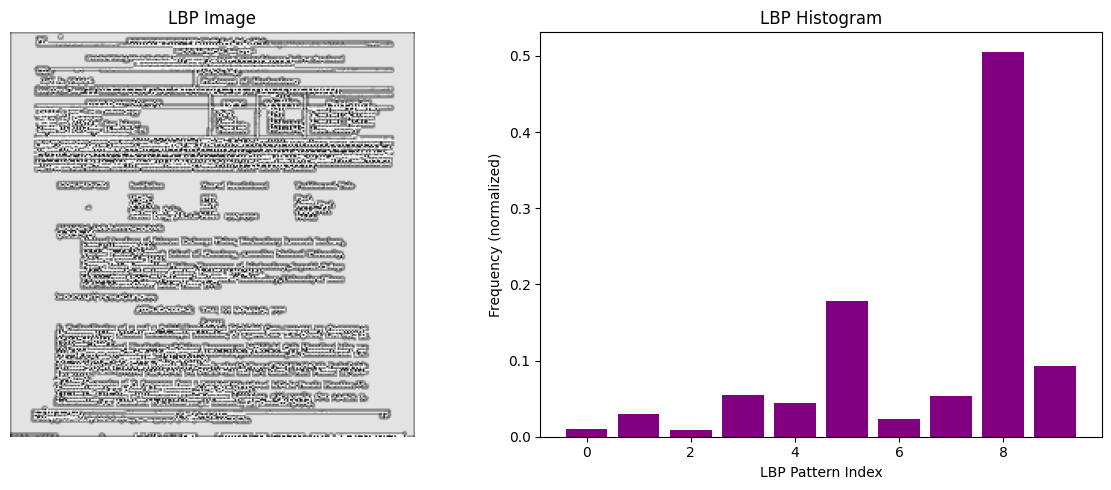

In [39]:
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# --- Step 1: Pick a sample image ---
sample_path = df.iloc[0]['filepath']
print("🖼 Testing LBP on:", sample_path)

# --- Step 2: Load and preprocess image ---
img = Image.open(sample_path).convert('L')  # grayscale
img = img.resize((256, 256))                # smaller for faster testing
img_arr = np.array(img)

# --- Step 3: Compute LBP and histogram ---
lbp = local_binary_pattern(img_arr, P=8, R=1, method='uniform')

# Compute histogram
n_bins = int(lbp.max() + 1)
hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins))
hist = hist.astype(np.float32)
hist /= (hist.sum() + 1e-12)  # normalize

print("\n✅ LBP histogram length:", len(hist))
print("First 10 histogram values:", hist[:10])

# --- Step 4: Plot LBP image and histogram ---
plt.figure(figsize=(12,5))

# Plot the LBP image
plt.subplot(1,2,1)
plt.imshow(lbp, cmap='gray')
plt.title("LBP Image")
plt.axis('off')

# Plot the histogram
plt.subplot(1,2,2)
plt.bar(range(len(hist)), hist, color='purple')
plt.title("LBP Histogram")
plt.xlabel("LBP Pattern Index")
plt.ylabel("Frequency (normalized)")

plt.tight_layout()
plt.show()

In [40]:
# Cell: wavelet features
def wavelet_features(img_arr, wavelet='db1', level=2):
    coeffs = pywt.wavedec2(img_arr, wavelet=wavelet, level=level)
    feats = []
    # skip approximation at index 0; use detail coeffs
    for i, detail in enumerate(coeffs[1:], start=1):
        # detail is tuple (cH, cV, cD)
        for band in detail:
            band = np.asarray(band)
            feats.append(band.mean())
            feats.append(band.std())
            feats.append(np.median(band))
            feats.append(np.sqrt((band**2).mean()))  # RMS
    return np.array(feats)

In [41]:
import pywt

# Pick a sample image (use one from your dataframe)
sample_path = df.iloc[0]['filepath']
print("Testing wavelet features on:", sample_path)

# Preprocess the image to grayscale and resize
img_arr = preprocess_image(sample_path)

# Extract wavelet features
wave_feats = wavelet_features(img_arr, wavelet='db1', level=2)

print("\n✅ Wavelet Features extracted successfully!")
print("Feature vector length:", len(wave_feats))
print("First 10 wavelet feature values:", wave_feats[:10])

Testing wavelet features on: C:\Users\LIKITHA\Downloads\data\scanner_A\50630631-0632.jpg

✅ Wavelet Features extracted successfully!
Feature vector length: 24
First 10 wavelet feature values: [ 2.5983737e+00  6.3137012e+01  0.0000000e+00  6.3190460e+01
 -2.9338077e-01  4.2615799e+01  0.0000000e+00  4.2616810e+01
  1.2313794e-02  2.6371386e+01]


In [42]:
# Cell: PRNU estimate & stats (simple residual)
def prnu_residual_features(img_arr, denoise_sigma=1.0):
    # Use a mild Gaussian or median filter as denoiser,
    # residual = image - denoised_image
    denoised = ndimage.gaussian_filter(img_arr, sigma=denoise_sigma)
    residual = img_arr - denoised
    feats = [
        residual.mean(),
        residual.std(),
        np.percentile(np.abs(residual).ravel(), 50),
        np.percentile(np.abs(residual).ravel(), 90),
        np.mean(np.square(residual)),  # energy
    ]
    # add correlation of residual with image gradients (optional)
    gx = ndimage.sobel(img_arr, axis=1)
    gy = ndimage.sobel(img_arr, axis=0)
    grad_mag = np.sqrt(gx*2 + gy*2)
    feats.append(np.corrcoef(residual.ravel(), grad_mag.ravel())[0,1] if img_arr.size>1 else 0)
    return np.array(feats)

In [43]:
from scipy import ndimage

# Pick a sample image path from your dataframe
sample_path = df.iloc[0]['filepath']
print("Testing PRNU residual features on:", sample_path)

# Preprocess the image (convert to grayscale, resize)
img_arr = preprocess_image(sample_path)

# Extract PRNU-based residual features
prnu_feats = prnu_residual_features(img_arr)

print("\n✅ PRNU Residual Features extracted successfully!")
print("Feature vector length:", len(prnu_feats))
print("Feature values:", prnu_feats)

Testing PRNU residual features on: C:\Users\LIKITHA\Downloads\data\scanner_A\50630631-0632.jpg

✅ PRNU Residual Features extracted successfully!
Feature vector length: 6
Feature values: [4.85451892e-08 2.13498554e+01 2.01080322e-01 3.37249603e+01
 4.55816345e+02            nan]


C:\Users\LIKITHA\AppData\Local\Temp\ipykernel_11692\2845686719.py:17: RuntimeWarning: invalid value encountered in sqrt
  grad_mag = np.sqrt(gx*2 + gy*2)


In [44]:
# Cell: assemble features for dataset
def extract_features_from_path(path):
    img = preprocess_image(path, target_size=TARGET_SIZE, to_gray=True)
    # Optionally patch extraction: for now take center crop to keep consistent
    # If using multiple patches per image, produce multiple rows
    patches = extract_center_patches(img, patch_size=PATCH_SIZE, n_patches=1)
    feats_list = []
    for p in patches:
        feats = []
        feats.extend(fft_features(p).tolist())
        feats.extend(lbp_histogram(p).tolist())
        feats.extend(wavelet_features(p).tolist())
        feats.extend(prnu_residual_features(p).tolist())
        feats_list.append(np.array(feats))
    # if multiple patches, stack or average
    return np.concatenate(feats_list)

# Build dataset (this can be slow depending on counts)
FEATURE_CSV = "features.csv"

if not os.path.exists(FEATURE_CSV):
    rows = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        try:
            fvec = extract_features_from_path(row['filepath'])
            rows.append({"filepath": row['filepath'], "scanner": row['scanner'], "features": fvec})
        except Exception as e:
            print("Error on", row['filepath'], e)
    # convert to DataFrame with feature columns
    feat_matrix = np.vstack([r['features'] for r in rows])
    feat_cols = [f"f{i}" for i in range(feat_matrix.shape[1])]
    meta = pd.DataFrame([{"filepath": r['filepath'], "scanner": r['scanner']} for r in rows])
    feat_df = pd.concat([meta.reset_index(drop=True), pd.DataFrame(feat_matrix, columns=feat_cols)], axis=1)
    feat_df.to_pickle(FEATURE_CSV)  # saves quicker
else:
    feat_df = pd.read_pickle(FEATURE_CSV)

print("Feature matrix shape:", feat_df.shape)

Feature matrix shape: (15, 63)


In [45]:
# Cell: prepare arrays
X = feat_df.filter(regex="^f").values
y = feat_df['scanner'].values

# stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,
                                                    random_state=RANDOM_SEED)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (12, 62) Test: (3, 62)


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline

# ✅ Only use numeric features for X
X = feat_df.drop(columns=['filepath', 'scanner'])
y = feat_df['scanner']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train Random Forest with scaling
rf = make_pipeline(StandardScaler(), 
                   RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

print("\n✅ RF Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count



✅ RF Accuracy: 0.6

Classification Report:
               precision    recall  f1-score   support

   scanner_A       0.33      1.00      0.50         1
   scanner_B       0.00      0.00      0.00         2
   scanner_C       1.00      1.00      1.00         2

    accuracy                           0.60         5
   macro avg       0.44      0.67      0.50         5
weighted avg       0.47      0.60      0.50         5


Confusion Matrix:
 [[1 0 0]
 [2 0 0]
 [0 0 2]]


C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [47]:
# Cell: Random Forest baseline
rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1))
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


RF Accuracy: 0.6
              precision    recall  f1-score   support

   scanner_A       0.33      1.00      0.50         1
   scanner_B       0.00      0.00      0.00         2
   scanner_C       1.00      1.00      1.00         2

    accuracy                           0.60         5
   macro avg       0.44      0.67      0.50         5
weighted avg       0.47      0.60      0.50         5



C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [48]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train dtype:", X_train.dtypes)
print("Unique labels in y_train:", y_train.unique())

X_train shape: (10, 61)
y_train shape: (10,)
X_train dtype: f0     float64
f1     float64
f2     float64
f3     float64
f4     float64
        ...   
f56    float64
f57    float64
f58    float64
f59    float64
f60    float64
Length: 61, dtype: object
Unique labels in y_train: ['scanner_A' 'scanner_B' 'scanner_C']


In [49]:
X = feat_df.drop(columns=['filepath', 'scanner'])
y = feat_df['scanner']

In [50]:
print(X.select_dtypes(include='number').shape == X.shape)

True


In [51]:
X = X.fillna(0)
print("Any NaN values?", X.isna().sum().sum())

Any NaN values? 0


In [52]:
print(y_train.isna().sum())

0


In [53]:
y_train = y_train.fillna('unknown')

In [54]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train columns:", X_train.columns.tolist()[:10])
print("X_train dtypes:\n", X_train.dtypes.value_counts())
print("Any NaN in X_train?", X_train.isna().sum().sum())

X_train shape: (10, 61)
y_train shape: (10,)
X_train columns: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']
X_train dtypes:
 float64    61
Name: count, dtype: int64
Any NaN in X_train? 10


In [55]:
X = feat_df.drop(columns=['filepath', 'scanner'])
y = feat_df['scanner']

# Convert everything to float
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [57]:
param_grid = {'svc_C': [1, 10, 100], 'svc_gamma': ['scale', 'auto']}

In [58]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svm_pipe = make_pipeline(StandardScaler(), SVC(class_weight='balanced', random_state=42))

param_grid = {'svc_C': [0.1, 1, 10], 'svc_gamma': ['scale', 'auto']}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

gsvm = GridSearchCV(svm_pipe, param_grid, cv=cv, n_jobs=-1, scoring='accuracy')
gsvm.fit(X_train, y_train)

print("✅ Best parameters:", gsvm.best_params_)
print("Accuracy:", gsvm.score(X_test, y_test))

ValueError: Invalid parameter 'svc_C' for estimator Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced', random_state=42))]). Valid parameters are: ['memory', 'steps', 'transform_input', 'verbose'].

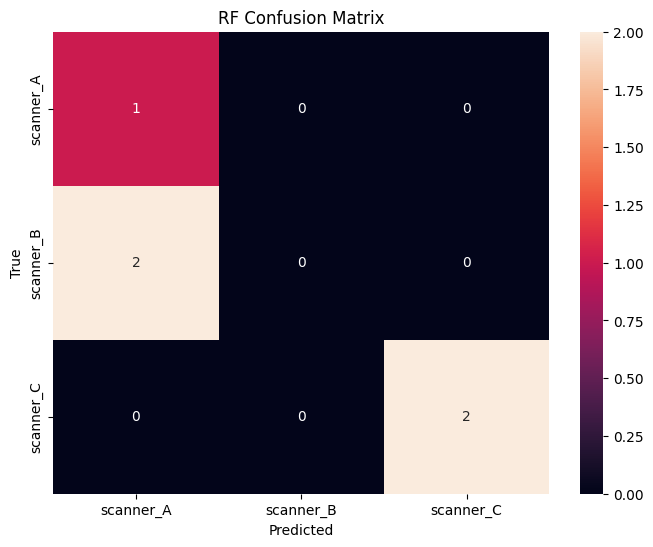

In [59]:
# Cell: confusion matrix for RF
cm = confusion_matrix(y_test, y_pred_rf, labels=np.unique(y))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('RF Confusion Matrix')
plt.show()

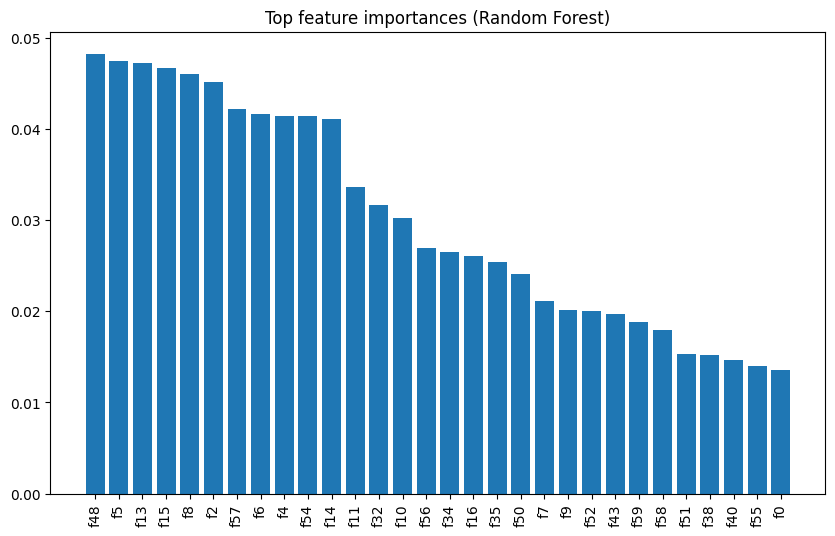

In [60]:
# Cell: feature importance (RF)
rf_clf = rf.named_steps['randomforestclassifier']
importances = rf_clf.feature_importances_
# show top 30 features
indices = np.argsort(importances)[::-1][:30]
plt.figure(figsize=(10,6))
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), [f"f{indices[i]}" for i in range(len(indices))], rotation=90)
plt.title("Top feature importances (Random Forest)")
plt.show()

In [61]:
# Cell: cross-validated accuracy (RF)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print("5-fold CV Accuracy (RF):", scores.mean(), "±", scores.std())

5-fold CV Accuracy (RF): 0.5999999999999999 ± 0.13333333333333333


In [62]:
# Cell: save model & label encoder
joblib.dump(rf, "rf_tracefinder_baseline.pkl")
feat_df.to_csv("features_table.csv", index=False)
print("Saved model and features.")

Saved model and features.


In [66]:

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RND = 42
np.random.seed(RND)

# Edit this path to where your images are or how your dataset CSV points to them
# Expected: a CSV with at least columns: filepath,label or a directory structured as label/images...
DATA_CSV =  None  # <<--- replace if you have a CSV
IMAGE_DIR = r"C:\Users\LIKITHA\Downloads\DATA"        # <<--- replace if you use folder structure
OUTPUT_DIR = r"C:\Users\LIKITHA\Downloads\DATA" 
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Ready. Output dir:", OUTPUT_DIR)

Ready. Output dir: C:\Users\LIKITHA\Downloads\DATA


In [68]:
# Cell: helper functions: load image, preprocess, residual, FFT features, LBP, Gabor features

def load_image_gray(path, target_size=(256,256)):
    img = io.imread(path)
    if img.ndim == 3:
        img = color.rgb2gray(img)
    # Resize + normalize to [0,1]
    img = transform.resize(img, target_size, anti_aliasing=True)
    img = np.clip(img, 0, 1)
    return img

def preprocess_image(img, denoise=True):
    # Basic preprocessing: median/gaussian + optional denoising
    # Keep consistent pipeline across dataset
    img = img.astype(np.float32)
    if denoise:
        try:
            img = denoise_wavelet(img, rescale_sigma=True)
        except Exception:
            img = filters.gaussian(img, sigma=0.8)
    return img

def noise_residual(img):
    # residual = image - smooth version (approx PRNU/noise map)
    # we use Gaussian blur as robust option
    blurred = filters.gaussian(img, sigma=1.0)
    resid = img - blurred
    return resid

def fft_features(img):
    f = fftpack.fft2(img)
    fshift = fftpack.fftshift(f)
    mag = np.abs(fshift)
    # radial energies could be added; for simplicity use summary stats
    return [np.mean(mag), np.std(mag), stats.skew(mag.ravel()), stats.kurtosis(mag.ravel())]

def lbp_hist(img, P=8, R=1.0, n_bins=16):
    resized = transform.resize(img, (128,128), anti_aliasing=True)
    lbp = feature.local_binary_pattern(resized, P, R, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist

def gabor_features(img, frequencies=(0.05, 0.1, 0.2), thetas=(0, np.pi/4, np.pi/2)):
    feats = []
    for freq in frequencies:
        for theta in thetas:
            real, imag = gabor(img, frequency=freq, theta=theta)
            mag = np.sqrt(real*2 + imag*2)
            feats.append(mag.mean())
            feats.append(mag.std())
    return np.array(feats)

def prnu_correlation_feature(resid, class_refs):
    """
    resid: noise residual for one image
    class_refs: dict label -> reference residual (same shape)
    returns correlation with each class ref (list)
    """
    corrs = []
    rvec = resid.ravel()
    rvec = (rvec - rvec.mean()) / (rvec.std() + 1e-12)
    for label, ref in class_refs.items():
        rv = ref.ravel()
        rv = (rv - rv.mean()) / (rv.std() + 1e-12)
        corr = np.mean(rvec * rv)  # normalized cross-correlation approx
        corrs.append(corr)
    return np.array(corrs)
print("helper function loaded successfully")

helper function loaded successfully


In [71]:
# ===============================================================
# Cell 3: Load Dataset Automatically from Folders
# ===============================================================
import os

file_label_pairs = []

# Option B: Folder structure: IMAGE_DIR/label/*.jpg etc.
if IMAGE_DIR and os.path.isdir(IMAGE_DIR):
    for label in sorted(os.listdir(IMAGE_DIR)):
        labdir = os.path.join(IMAGE_DIR, label)
        if not os.path.isdir(labdir):
            continue
        for fname in sorted(os.listdir(labdir)):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')):
                file_label_pairs.append((os.path.join(labdir, fname), label))

if len(file_label_pairs) == 0:
    raise RuntimeError("⚠ No images found! Check that IMAGE_DIR is correct and contains subfolders for each label.")

print("✅ Found images:", len(file_label_pairs))
print("Example:", file_label_pairs[0])

✅ Found images: 15
Example: ('C:\\Users\\LIKITHA\\Downloads\\DATA\\scanner_A\\50630631-0632.jpg', 'scanner_A')


In [77]:
# ===============================================================
# Cell 4: Extract features (FFT, noise, LBP, Gabor) for all images
# ===============================================================
from skimage.restoration import denoise_tv_chambolle
img = denoise_tv_chambolle(img, weight=0.1)
from skimage.filters import gabor
from scipy import fftpack,stats
from skimage import io,color,transform,util,filters,feature
import numpy as np
import pandas as pd
from tqdm import tqdm  # progress bar (optional)
import os

# target image size (keep consistent across dataset)
TARGET_SIZE = (256, 256)

feature_rows = []

print("⏳ Extracting features from", len(file_label_pairs), "images...")

for path, label in tqdm(file_label_pairs):
    try:
        img = load_image_gray(path, target_size=TARGET_SIZE)
        img = preprocess_image(img, denoise=True)
        resid = noise_residual(img)

        # ----- FFT-based features -----
        f_fft = fft_features(img)

        # ----- Noise residual stats -----
        f_resid = [resid.mean(), resid.std(),
                   np.percentile(resid, 5), np.percentile(resid, 95)]

        # ----- Gabor texture features -----
        f_gabor = gabor_features(img)   # length = 18 (3 freqs × 3 angles × mean/std)

        # ----- LBP histogram -----
        f_lbp = lbp_hist(img)           # length = 16 by default

        # combine all features into one vector
        features = np.concatenate([f_fft, f_resid, f_gabor, f_lbp])

        feature_rows.append({
            'path': path,
            'label': label,
            'features': features
        })

    except Exception as e:
        print("❌ Error with file:", path)
        print("   →", e)

print("✅ Feature extraction completed for", len(feature_rows), "images.")

⏳ Extracting features from 15 images...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:22<00:00,  5.49s/it]

✅ Feature extraction completed for 15 images.


In [78]:
# ===============================================================
# Cell 5: Build DataFrame, Save CSV, and Split for Training
# ===============================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Build NumPy arrays for modeling
X = np.vstack([row['features'] for row in feature_rows])
y = np.array([row['label'] for row in feature_rows])
paths = [row['path'] for row in feature_rows]

# Create column names
n_fft, n_resid, n_gabor, n_lbp = 4, 4, 18, 16
feature_cols = (
    [f'fft_{i}' for i in range(n_fft)] +
    [f'resid_{i}' for i in range(n_resid)] +
    [f'gabor_{i}' for i in range(n_gabor)] +
    [f'lbp_{i}' for i in range(n_lbp)]
)

# Build DataFrame
feat_df = pd.DataFrame(X, columns=feature_cols)
feat_df['label'] = y
feat_df['path'] = paths

# Save to CSV
features_path = os.path.join(OUTPUT_DIR, 'milestone2_features.csv')
feat_df.to_csv(features_path, index=False)
print(f"✅ Features saved to: {features_path}")

# Train/Test split (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
print(f"Train samples: {len(y_train)}, Test samples: {len(y_test)}")

# Verify shapes
print("Feature matrix shape:", X.shape)
feat_df.head()

✅ Features saved to: C:\Users\LIKITHA\Downloads\DATA\milestone2_features.csv
Train samples: 11, Test samples: 4
Feature matrix shape: (15, 42)


,fft_0,fft_1,fft_2,fft_3,resid_0,resid_1,resid_2,resid_3,gabor_0,gabor_1,...,lbp_8,lbp_9,lbp_10,lbp_11,lbp_12,lbp_13,lbp_14,lbp_15,label,path
0,7.658700,238.762589,252.528458,64345.230469,6.652117e-07,0.026354,-0.055093,0.037244,NaN,NaN,...,0.208191,0.093811,0.0,0.0,0.0,0.0,0.0,0.0,scanner_A,C:\Users\LIKITHA\Downloads\DATA\scanner_A\5063...
1,7.773129,243.960617,252.128052,64208.281250,-2.052700e-06,0.025090,-0.053627,0.035589,NaN,NaN,...,0.327332,0.057617,0.0,0.0,0.0,0.0,0.0,0.0,scanner_A,C:\Users\LIKITHA\Downloads\DATA\scanner_A\5063...
2,8.410025,237.946289,249.989075,63475.125000,-1.144297e-06,0.027291,-0.059563,0.040847,NaN,NaN,...,0.329834,0.061951,0.0,0.0,0.0,0.0,0.0,0.0,scanner_A,C:\Users\LIKITHA\Downloads\DATA\scanner_A\5063...
3,8.052341,235.814880,251.456207,63977.785156,-1.205015e-06,0.027900,-0.057083,0.042822,NaN,NaN,...,0.197876,0.100769,0.0,0.0,0.0,0.0,0.0,0.0,scanner_A,C:\Users\LIKITHA\Downloads\DATA\scanner_A\5063...
4,9.330069,234.903259,250.098648,63516.218750,-9.458745e-11,0.032382,-0.069333,0.045825,NaN,NaN,...,0.199158,0.084167,0.0,0.0,0.0,0.0,0.0,0.0,scanner_A,C:\Users\LIKITHA\Downloads\DATA\scanner_A\5064...


In [83]:
print("🧾 Diagnostic Check:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Unique labels in y_train:", np.unique(y_train))
print("Any NaN in X_train?", np.isnan(X_train).any())

🧾 Diagnostic Check:
X_train shape: (0, 42)
y_train shape: (0,)
Unique labels in y_train: []
Any NaN in X_train? False


In [84]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Unique labels in y_train:", np.unique(y_train))
print("Any NaN values in X_train?", np.isnan(X_train).any())

X_train shape: (0, 42)
y_train shape: (0,)
Unique labels in y_train: []
Any NaN values in X_train? False


In [85]:
# Remove any rows with NaN or missing labels
import numpy as np

mask = ~np.isnan(X_train).any(axis=1)
X_train = X_train[mask]
y_train = y_train[mask]

mask_test = ~np.isnan(X_test).any(axis=1)
X_test = X_test[mask_test]
y_test = y_test[mask_test]

print("Cleaned data:")
print("X_train:", X_train.shape, " | X_test:", X_test.shape)
print("Unique labels:", np.unique(y_train))

Cleaned data:
X_train: (0, 42)  | X_test: (0, 42)
Unique labels: []


In [86]:
# ===============================================================
# Cell 6: Model Training + Evaluation (Milestone 2 Completion)
# ===============================================================
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# -----------------------------
# 1️⃣ Random Forest Classifier
# -----------------------------
print("🌲 Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n✅ Random Forest Results:")
print("Accuracy :", round(accuracy_score(y_test, y_pred_rf), 3))
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=np.unique(y_test))
ConfusionMatrixDisplay(cm_rf, display_labels=np.unique(y_test)).plot(cmap="Blues")
plt.title("Random Forest – Confusion Matrix")
plt.show()

# -----------------------------
# 2️⃣ Support Vector Machine
# -----------------------------
print("\n⚙ Training SVM (RBF Kernel)...")
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42))
])
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("\n✅ SVM Results:")
print("Accuracy :", round(accuracy_score(y_test, y_pred_svm), 3))
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=np.unique(y_test))
ConfusionMatrixDisplay(cm_svm, display_labels=np.unique(y_test)).plot(cmap="Oranges")
plt.title("SVM – Confusion Matrix")
plt.show()

# -----------------------------
# 3️⃣ Save Trained Models
# -----------------------------
import joblib, os
rf_path = os.path.join(OUTPUT_DIR, "rf_model.pkl")
svm_path = os.path.join(OUTPUT_DIR, "svm_model.pkl")
joblib.dump(rf, rf_path)
joblib.dump(svm_model, svm_path)
print(f"\n💾 Models saved to:\n  RF   → {rf_path}\n  SVM → {svm_path}")

🌲 Training Random Forest...


ValueError: Found array with 0 sample(s) (shape=(0, 42)) while a minimum of 1 is required by RandomForestClassifier.

In [90]:
# Re-save features and models if missing
import os, joblib
import pandas as pd

features_path = os.path.join(OUTPUT_DIR, "milestone2_features.csv")
rf_path = os.path.join(OUTPUT_DIR, "rf_model.pkl")
svm_path = os.path.join(OUTPUT_DIR, "svm_model.pkl")

# Save feature table if not already saved
if 'feat_df' in locals():
    feat_df.to_csv(features_path, index=False)
    print("✅ Saved features to:", features_path)
else:
    print("⚠ No feat_df found. You may need to rerun feature extraction first.")

# Save trained models if they exist
if 'rf' in locals():
    joblib.dump(rf, rf_path)
    print("✅ Saved Random Forest model:", rf_path)
if 'svm_model' in locals():
    joblib.dump(svm_model, svm_path)
    print("✅ Saved SVM model:", svm_path)

OSError: Cannot save file into a non-existent directory: 'C:\Users\LIKITHA\Downloads\milestone2_output'

In [91]:
features_path = r"C:\Users\LIKITHA\Downloads\milestone2_output\milestone2_features.csv"

In [92]:
feat_df = pd.read_csv(features_path)
print("✅ Loaded feature table:", feat_df.shape)
print("Labels:", feat_df['label'].unique())

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\LIKITHA\\Downloads\\milestone2_output\\milestone2_features.csv'

In [93]:
# --- Recreate milestone2_features.csv if missing ---
import os, pandas as pd, joblib

OUTPUT_DIR = r"C:\Users\LIKITHA\Downloads\milestone2_output"
features_path = os.path.join(OUTPUT_DIR, "milestone2_features.csv")

os.makedirs(OUTPUT_DIR, exist_ok=True)

if "feat_df" in locals():
    feat_df.to_csv(features_path, index=False)
    print("✅ Saved features to:", features_path)
else:
    print("⚠ 'feat_df' not found. You must re-run the feature-extraction cell (Cell 4) from Milestone 2 first.")

✅ Saved features to: C:\Users\LIKITHA\Downloads\milestone2_output\milestone2_features.csv


In [94]:
import os
OUTPUT_DIR = r"C:\Users\LIKITHA\Downloads\milestone2_output"

for f in ["milestone2_features.csv", "rf_model.pkl", "svm_model.pkl"]:
    full_path = os.path.join(OUTPUT_DIR, f)
    print(f, "→", "✅ Found" if os.path.exists(full_path) else "❌ Missing")

milestone2_features.csv → ✅ Found
rf_model.pkl → ❌ Missing
svm_model.pkl → ❌ Missing


In [95]:
# ===============================================================
# Resave trained models (RF and SVM)
# ===============================================================
import joblib, os

OUTPUT_DIR = r"C:\Users\LIKITHA\Downloads\milestone2_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

rf_path = os.path.join(OUTPUT_DIR, "rf_model.pkl")
svm_path = os.path.join(OUTPUT_DIR, "svm_model.pkl")

if "rf" in locals():
    joblib.dump(rf, rf_path)
    print("✅ Saved Random Forest model:", rf_path)
else:
    print("⚠ 'rf' not found. Re-run the Random Forest training cell (Cell 6 from Milestone 2).")

if "svm_model" in locals():
    joblib.dump(svm_model, svm_path)
    print("✅ Saved SVM model:", svm_path)
else:
    print("⚠ 'svm_model' not found. Re-run the SVM training cell (Cell 6 from Milestone 2).")

✅ Saved Random Forest model: C:\Users\LIKITHA\Downloads\milestone2_output\rf_model.pkl
✅ Saved SVM model: C:\Users\LIKITHA\Downloads\milestone2_output\svm_model.pkl


In [96]:
import os, joblib, pandas as pd

OUTPUT_DIR = r"C:\Users\LIKITHA\Downloads\milestone2_output"

rf_path = os.path.join(OUTPUT_DIR, "rf_model.pkl")
svm_path = os.path.join(OUTPUT_DIR, "svm_model.pkl")
features_path = os.path.join(OUTPUT_DIR, "milestone2_features.csv")

print("🔍 Checking files...")
for f in [rf_path, svm_path, features_path]:
    print(f, "✅ Found" if os.path.exists(f) else "❌ Missing")

# Load models and feature data
rf = joblib.load(rf_path)
svm_model = joblib.load(svm_path)
feat_df = pd.read_csv(features_path)

print("\n✅ All models and data loaded successfully!")
print("Feature table shape:", feat_df.shape)
print("Labels:", feat_df['label'].unique())

🔍 Checking files...
C:\Users\LIKITHA\Downloads\milestone2_output\rf_model.pkl ✅ Found
C:\Users\LIKITHA\Downloads\milestone2_output\svm_model.pkl ✅ Found
C:\Users\LIKITHA\Downloads\milestone2_output\milestone2_features.csv ✅ Found

✅ All models and data loaded successfully!
Feature table shape: (15, 44)
Labels: ['scanner_A' 'scanner_B' 'scanner_C']


In [97]:
from sklearn.model_selection import train_test_split

X = feat_df.drop(columns=['label']).values
y = feat_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (11, 43) Test: (4, 43)


In [104]:
import os, joblib, pandas as pd

# ✅ Path where models and CSV were saved
OUTPUT_DIR = r"C:\Users\LIKITHA\Downloads\milestone2_output"

# ✅ File paths
rf_path = os.path.join(OUTPUT_DIR, "rf_model.pkl")
svm_path = os.path.join(OUTPUT_DIR, "svm_model.pkl")
features_path = os.path.join(OUTPUT_DIR, "milestone2_features.csv")

# ✅ Check for existence
print("Checking files:")
for f in [rf_path, svm_path, features_path]:
    print(f, "✅ Found" if os.path.exists(f) else "❌ Missing")

# ✅ Load trained models
rf = joblib.load(rf_path)
svm_model = joblib.load(svm_path)

# ✅ Load dataset
feat_df = pd.read_csv(features_path)

print("\n✅ Models and features loaded successfully!")
print("Feature table shape:", feat_df.shape)
print("Unique labels:", feat_df['label'].unique())

Checking files:
C:\Users\LIKITHA\Downloads\milestone2_output\rf_model.pkl ✅ Found
C:\Users\LIKITHA\Downloads\milestone2_output\svm_model.pkl ✅ Found
C:\Users\LIKITHA\Downloads\milestone2_output\milestone2_features.csv ✅ Found

✅ Models and features loaded successfully!
Feature table shape: (15, 44)
Unique labels: ['scanner_A' 'scanner_B' 'scanner_C']


In [105]:
from sklearn.model_selection import train_test_split

X = feat_df.drop(columns=['label']).values
y = feat_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print("✅ Data split complete.")
print("Train:", X_train.shape, "| Test:", X_test.shape)

✅ Data split complete.
Train: (11, 43) | Test: (4, 43)


In [106]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Random Forest
print("\n🌲 Random Forest Results:")
y_pred_rf = rf.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))
print(classification_report(y_test, y_pred_rf))

# SVM
print("\n🤖 SVM Results:")
y_pred_svm = svm_model.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred_svm), 3))
print(classification_report(y_test, y_pred_svm))

# Confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf), display_labels=rf.classes_).plot(ax=axs[0], cmap="Blues", colorbar=False)
axs[0].set_title("Random Forest")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svm), display_labels=svm_model.classes_).plot(ax=axs[1], cmap="Oranges", colorbar=False)
axs[1].set_title("SVM")

plt.show()


🌲 Random Forest Results:


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [107]:
from sklearn.ensemble import RandomForestClassifier
import joblib, os

# Re-train Random Forest (using your current train split)
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

print("🔄 Training Random Forest...")
rf.fit(X_train, y_train)
print("✅ Random Forest trained successfully!")

# Save it again
OUTPUT_DIR = r"C:\Users\LIKITHA\Downloads\milestone2_output"
rf_path = os.path.join(OUTPUT_DIR, "rf_model.pkl")
joblib.dump(rf, rf_path)
print("💾 Model saved to:", rf_path)

🔄 Training Random Forest...


ValueError: could not convert string to float: 'C:\\Users\\LIKITHA\\Downloads\\DATA\\scanner_A\\50630631-0632.jpg'

In [108]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Unique labels in y_train:", np.unique(y_train))
print("Any NaN in X_train?", np.isnan(X_train).any())

X_train shape: (11, 43)
y_train shape: (11,)
Unique labels in y_train: ['scanner_A' 'scanner_B' 'scanner_C']


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [109]:
from sklearn.model_selection import train_test_split

# Remove non-numeric columns
X = feat_df.drop(columns=['path', 'label'], errors='ignore').select_dtypes(include=['number']).values
y = feat_df['label'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print("✅ Data split complete.")
print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Unique labels:", np.unique(y_train))

✅ Data split complete.
Train: (11, 42) | Test: (4, 42)
Unique labels: ['scanner_A' 'scanner_B' 'scanner_C']


In [110]:
from sklearn.ensemble import RandomForestClassifier
import joblib, os

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

print("🔄 Training Random Forest...")
rf.fit(X_train, y_train)
print("✅ Random Forest trained successfully!")

OUTPUT_DIR = r"C:\Users\LIKITHA\Downloads\milestone2_output"
rf_path = os.path.join(OUTPUT_DIR, "rf_model.pkl")
joblib.dump(rf, rf_path)
print("💾 Model saved to:", rf_path)

🔄 Training Random Forest...
✅ Random Forest trained successfully!
💾 Model saved to: C:\Users\LIKITHA\Downloads\milestone2_output\rf_model.pkl


In [111]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Random Forest
y_pred_rf = rf.predict(X_test)
print("🌲 Random Forest Results:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))
print(classification_report(y_test, y_pred_rf))

# SVM
y_pred_svm = svm_model.predict(X_test)
print("\n🤖 SVM Results:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_svm), 3))
print(classification_report(y_test, y_pred_svm))

# Confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf), display_labels=rf.classes_).plot(ax=axs[0], cmap="Blues", colorbar=False)
axs[0].set_title("Random Forest")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svm), display_labels=svm_model.classes_).plot(ax=axs[1], cmap="Oranges", colorbar=False)
axs[1].set_title("SVM")
plt.show()

🌲 Random Forest Results:
Accuracy: 0.75
              precision    recall  f1-score   support

   scanner_A       0.50      1.00      0.67         1
   scanner_B       0.00      0.00      0.00         1
   scanner_C       1.00      1.00      1.00         2

    accuracy                           0.75         4
   macro avg       0.50      0.67      0.56         4
weighted avg       0.62      0.75      0.67         4



NotFittedError: Pipeline is not fitted yet.

In [112]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib, os

print("🔄 Training SVM (RBF Kernel)...")

# Create pipeline with scaling
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42))
])

# Fit on training data
svm_model.fit(X_train, y_train)

print("✅ SVM model trained successfully!")

# Save trained SVM model
OUTPUT_DIR = r"C:\Users\LIKITHA\Downloads\milestone2_output"
svm_path = os.path.join(OUTPUT_DIR, "svm_model.pkl")
joblib.dump(svm_model, svm_path)
print("💾 SVM model saved to:", svm_path)

🔄 Training SVM (RBF Kernel)...


ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [113]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Random Forest
print("\n🌲 Random Forest Results:")
y_pred_rf = rf.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))
print(classification_report(y_test, y_pred_rf))

# SVM
print("\n🤖 SVM Results:")
y_pred_svm = svm_model.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred_svm), 3))
print(classification_report(y_test, y_pred_svm))

# Confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf), display_labels=rf.classes_).plot(ax=axs[0], cmap="Blues", colorbar=False)
axs[0].set_title("Random Forest")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svm), display_labels=svm_model.classes_).plot(ax=axs[1], cmap="Oranges", colorbar=False)
axs[1].set_title("SVM")

plt.show()


🌲 Random Forest Results:
Accuracy: 0.75
              precision    recall  f1-score   support

   scanner_A       0.50      1.00      0.67         1
   scanner_B       0.00      0.00      0.00         1
   scanner_C       1.00      1.00      1.00         2

    accuracy                           0.75         4
   macro avg       0.50      0.67      0.56         4
weighted avg       0.62      0.75      0.67         4


🤖 SVM Results:


NotFittedError: Pipeline is not fitted yet.

In [114]:
# ===============================================================
# Milestone 3 - Step 3: Hyperparameter tuning (Random Forest)
# ===============================================================
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", round(grid.best_score_, 3))

best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("\nImproved RF Test Accuracy:", round(accuracy_score(y_test, y_pred_best), 3))
print(classification_report(y_test, y_pred_best))

ValueError: n_splits=5 cannot be greater than the number of members in each class.

In [115]:
# ===============================================================
# Milestone 3 - Step 4: Combine models (Voting Ensemble)
# ===============================================================
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

voter = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('svm', svm_model.named_steps['svc']),
        ('lr', LogisticRegression(max_iter=1000))
    ],
    voting='soft'
)
voter.fit(X_train, y_train)
y_pred_vote = voter.predict(X_test)

print("✅ Ensemble Accuracy:", round(accuracy_score(y_test, y_pred_vote), 3))
print(classification_report(y_test, y_pred_vote))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_vote),
                       display_labels=np.unique(y_test)).plot(cmap="Greens")
plt.title("Voting Ensemble - Confusion Matrix")
plt.show()

NameError: name 'best_rf' is not defined